# Visualizing CNN Filters in Keras Models using Colab
Welcome to this Colab notebook that will guide you through the process of visualizing filters in Convolutional Neural Networks (CNNs) using Keras. In this tutorial, we will explore two popular CNN architectures: VGG19 and a custom CNN model trained on the Cats vs Dogs dataset.

Understanding the filters within CNN models can provide valuable insights into how these models learn and extract features from images. By visualizing these filters, we can gain a deeper understanding of the inner workings of CNNs and observe the learned representations.

**Key Features:**

- **Visualize filters in VGG19**: We will start by loading the pre-trained VGG19 model, exploring its layers, and visualizing the filters in selected layers.
- **Visualize a custom CNN model**: Next, we will also visualize filters in a custom CNN model trained on the Cats vs Dogs dataset.
- **Step-by-step guide**: This notebook provides a detailed, step-by-step guide, accompanied by code examples, that makes it easy for both technical and non-technical audiences to follow along.

**Prerequisites:**

To make the most of this tutorial, you should have:

- A basic understanding of deep learning concepts
- Familiarity with Python programming and the Keras library
- Recommended knowledge of CNN architectures and their applications


## Setting up imports and inputs

In [ ]:
import os
import time
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, load_model



    
`generate_random_image`:

Generates a random image tensor with the specified shape.

Params:

- shape (tuple): The shape of the image tensor in the format (height, width, channels).
- seed (int): Optional. The seed value for the random number generator.

Returns: 
- tensor: A randomly generated image tensor.

    

In [ ]:
def generate_random_image(shape = (96, 96 , 3), seed = None):
    return tf.random.uniform(shape = shape, minval = 0, maxval = 1, dtype= tf.dtypes.float32, seed = seed)

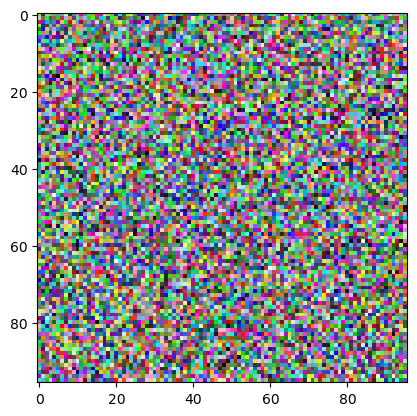

In [ ]:
img = generate_random_image()
plt.imshow(img)

`create_submodel` : 
Creates a submodel by extracting a specific layer from the given model.

Parameters:
- model (tf.keras.Model): The original model from which to extract the layer.
- layer_name (str): The name of the layer to extract from the model.
- verbose (bool): Optional. If True, prints a summary of the submodel.

Returns:
- tf.keras.Model: The submodel containing the specified layer.

In [ ]:
def create_submodel(model = None, layer_name = None, verbose = True):
    submodel = Model(inputs = model.input, outputs = model.get_layer(layer_name).output)
    if verbose:
        submodel.summary()
        
    return submodel

## VGG19 model filters

In [ ]:
# load a pre-trained VGG19 model
from tensorflow.keras.applications import VGG19

vgg19 = VGG19(input_shape= (96, 96, 3), include_top= False, weights = 'imagenet')

# create a VGG19 submodel
submodel = create_submodel(vgg19, 'block1_conv2', verbose = True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


`normalize_tensor` :  
Normalizes a tensor by scaling its values between 0 and 1.

Parameters:
- tensor (tf.Tensor): The input tensor to be normalized.

Returns:
- tf.Tensor: The normalized tensor.

In [ ]:

def normalize_tensor(tensor):
    min_val = tf.reduce_min(tensor)
    max_val = tf.reduce_max(tensor)
    normalized_tensor = tf.math.divide(tf.subtract(tensor, min_val), tf.subtract(max_val, min_val))
    return normalized_tensor


`train_filter` : Trains a filter within a model to maximize its activation for a given input image.

Parameters:
- input_img (tf.Tensor): The input image to be optimized.
- model (tf.keras.Model): The model containing the filter to be trained.
- filter_index (int): Optional. The index of the filter to be trained. If None, the first filter is trained.
- epochs (int): Optional. The number of optimization iterations.
- step (float): Optional. The step size for each optimization iteration.
- verbose (bool): Optional. If True, prints the loss at regular intervals.
- log_rate (float): Optional. Determines the frequency of loss logging, as a fraction of the total epochs.

Returns:
- tf.Tensor: The optimized input image.
- list: A list of loss values at each logged epoch.

In [ ]:
def train_filter(input_img, model, filter_index = None, epochs = 30, step = 10, verbose = False, log_rate = 0.2):
    losses = []
    for i in range(epochs):
        
        with tf.GradientTape() as tape:
            loss = 0
            tape.watch(input_img)
            output = model(tf.expand_dims(input_img, axis = 0))[:,:,:, filter_index]
            loss = tf.math.reduce_mean(output)
            
            if verbose:
                if i % int(epochs * log_rate) == 0:
                    losses.append(float(loss))
                    print(f'EPOCH {i} LOSS : {float(loss)}')
            
        grads = tape.gradient(loss, input_img)
        grads = tf.math.l2_normalize(grads)
        input_img += grads * step
        
        input_img = normalize_tensor(input_img)
    
    return input_img, losses


EPOCH 0 LOSS : 1.0535107851028442
EPOCH 20 LOSS : 2.789926767349243
EPOCH 40 LOSS : 2.850693702697754
EPOCH 60 LOSS : 2.858334541320801
EPOCH 80 LOSS : 2.8568344116210938
0.5998940467834473


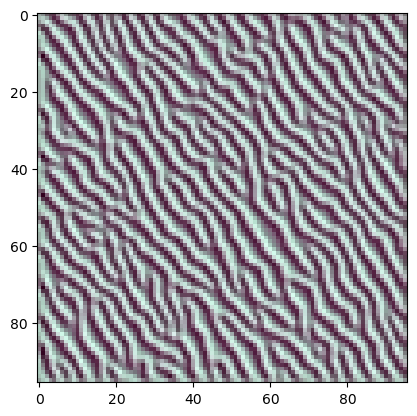

In [ ]:
beg = time.time()
newimg,_ = train_filter(img, submodel, 5,epochs = 100, verbose = True)
print(time.time() - beg)
newimg = tf.cast(255 * newimg, dtype=tf.int32).numpy()


plt.imshow(newimg)

In [ ]:
def check_and_create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Directory created: {path}")
    elif not os.path.isdir(path):
        print(f"Error: {path} is not a directory.")
    else:
        print(f"Directory already exists: {path}")

`visualize_filters_in_layer `:   
Visualizes filters in a specific layer of a submodel.

Parameters:
- input_img (tf.Tensor): The input image for training the filters.
- submodel (tf.keras.Model): The submodel containing the desired layer.
- layer_name (str): The name of the layer to visualize the filters from.
- n_filters (int): Optional. The number of filters to visualize. Defaults to -1, which visualizes all filters.
- epochs (int): Optional. The number of optimization iterations for training each filter.
- step (float): Optional. The step size for each optimization iteration.
- fig_size (tuple): Optional. The figure size for the visualization.

Returns:
- None


In [ ]:
def visualize_filters_in_layer(input_img, submodel, layer_name, n_filters = -1, 
                               epochs = 30, step = 10, fig_size = (10,10), save_dir = os.getcwd()):

    total_layer_filters = submodel.output_shape[-1]
    if n_filters == -1:
        n_filters = total_layer_filters 
    
    print(f'Processing {n_filters} filters in {layer_name} layer')

    if n_filters <= 4:
        rows = 1
    elif n_filters <= 8:
        rows = 2
    elif n_filters <= 32:
        rows = 4
    else:
        rows = 8
    
    cols = n_filters // rows
    #print(n_filters)
    #print(cols)
    fig = plt.figure(figsize = fig_size )
    
    if n_filters == total_layer_filters:
        for filter_idx in range(n_filters):      
            filter,_  = train_filter(input_img, submodel, filter_index = filter_idx, 
                                        epochs = 30, step = 10, verbose = False)
            fig.add_subplot(rows, cols, filter_idx + 1)
            plt.subplots_adjust(hspace=0.6)
            plt.imshow(filter)
            plt.axis('off')
            plt.title(str(filter_idx), pad = 10)
    else:
        random_filter_idxs = sorted([random.randint(0, total_layer_filters-1) for _ in range(n_filters)])
        #print(random_filter_idxs)
        for i, filter_idx in enumerate(random_filter_idxs):      
            filter,_  = train_filter(input_img, submodel, filter_index = filter_idx, 
                                        epochs = 30, step = 10, verbose = False)
        
            fig.add_subplot(rows, cols, i + 1)
            #plt.subplots_adjust(hspace=0.6)
            plt.imshow(filter)
            plt.axis('off')
            plt.title(str(filter_idx), pad = 1)

    
    # Set the figure title
    fig.suptitle(f'{layer_name} filters ( {n_filters} / {total_layer_filters})')
    # if save_dir does not exist -> create a new save_dir
    check_and_create_directory(save_dir)
    save_file = os.path.join('.',save_dir, f'{layer_name} filters.png')
    # Save the figure to a file
    plt.savefig(save_file)  # Save as PNG format

Processing 16 filters in block1_conv2 layer
Directory already exists: /kaggle/working


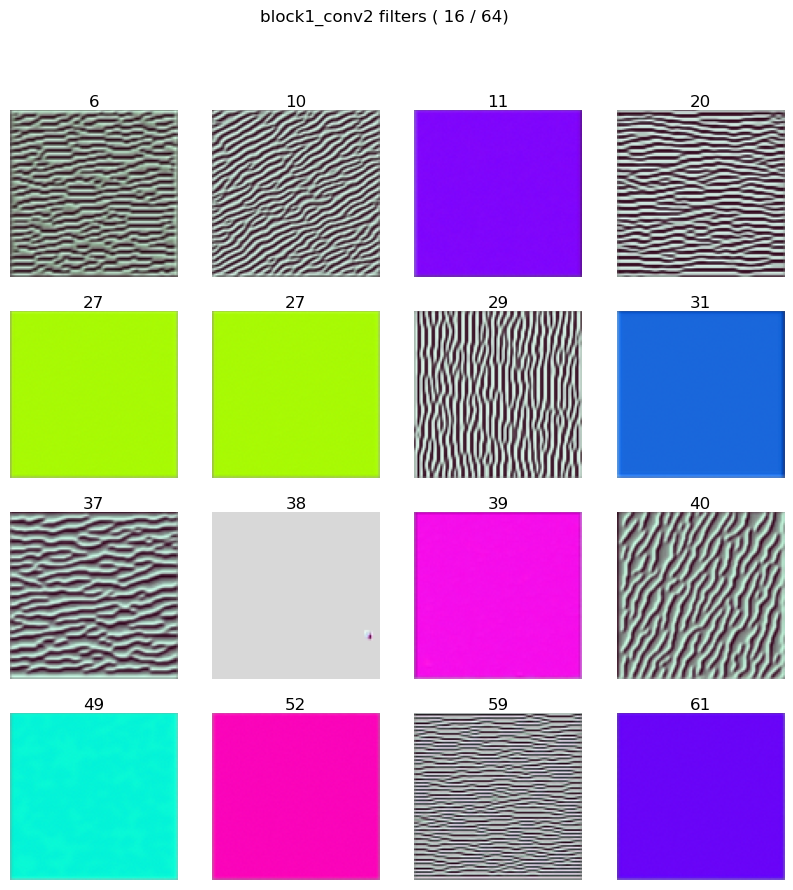

In [ ]:
visualize_filters_in_layer(input_img = img, submodel = submodel, 
                       layer_name = 'block1_conv2', n_filters = 16, epochs = 30, 
                       step = 10, fig_size = (10,10))

`save_all_filters` :   
Saves the visualizations of filters in multiple layers of a given model.

Parameters:
- input_img (tf.Tensor): The input image for training the filters.
- model (tf.keras.Model): The model containing the desired layers.
- layer_names (list): Optional. A list of layer names to visualize the filters from. Defaults to an empty list.
- n_filters (int): Optional. The number of filters to visualize. Defaults to 16.
- epochs (int): Optional. The number of optimization iterations for training each filter. Defaults to 30.
- step (float): Optional. The step size for each optimization iteration. Defaults to 10.
- fig_size (tuple): Optional. The figure size for the visualizations. Defaults to (10, 10).

Returns:
- None


In [ ]:
def save_all_filters(input_img, model, layer_names =[], n_filters = 16, 
                     epochs = 30, step = 10, fig_size = (10,10), save_dir = os.getcwd()):

    for layer_name in layer_names:

        submodel = create_submodel(model, layer_name, verbose = False)

        visualize_filters_in_layer(input_img, submodel, 
                       layer_name, n_filters = n_filters, epochs = 30, 
                       step = 10, fig_size = (10,10), save_dir = save_dir)
        



## Custom CNN model filters

In [ ]:
layer_names = [layer.name for layer in vgg19.layers if 'conv' in layer.name]
print(layer_names)
save_all_filters(input_img = img, layer_names = layer_names, 
                 model = vgg19, n_filters = 16, 
                 epochs = 30, step = 10, save_dir = 'VGG19'
                 )

In [ ]:
!git clone https://github.com/mohamedamine99/Visualizing-what-convnets-learn.git

Cloning into 'Visualizing-what-convnets-learn'...
remote: Enumerating objects: 2378, done.
remote: Counting objects: 100% (352/352), done.
remote: Compressing objects: 100% (266/266), done.
remote: Total 2378 (delta 108), reused 303 (delta 78), pack-reused 2026
Receiving objects: 100% (2378/2378), 619.23 MiB | 26.07 MiB/s, done.
Resolving deltas: 100% (111/111), done.
Updating files: 100% (2193/2193), done.


In [ ]:
cnn_model = load_model('./Visualizing-what-convnets-learn/models/CNN cats vs dogs model.hdf5')
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 61, 61, 64)      

In [ ]:
print(cnn_model.input_shape)
print(cnn_model.input_shape[1:])

(None, 128, 128, 3)
(128, 128, 3)


In [ ]:

layer_names = [layer.name for layer in cnn_model.layers if 'conv' in layer.name]
print(layer_names)
img = generate_random_image(shape = cnn_model.input_shape[1:], seed = None)
save_all_filters(input_img = img, layer_names = layer_names, 
                 model = cnn_model, n_filters = 16, 
                 epochs = 30, step = 10, save_dir = 'CNN'
                 )

## Saving results

In [ ]:
!zip -r VGG19_outputs.zip ./VGG19

  adding: VGG19/ (stored 0%)
  adding: VGG19/block1_conv2 filters.png (deflated 1%)
  adding: VGG19/block4_conv2 filters.png (deflated 0%)
  adding: VGG19/block3_conv4 filters.png (deflated 0%)
  adding: VGG19/block4_conv3 filters.png (deflated 0%)
  adding: VGG19/block4_conv1 filters.png (deflated 0%)
  adding: VGG19/block5_conv1 filters.png (deflated 0%)
  adding: VGG19/block1_conv1 filters.png (deflated 1%)
  adding: VGG19/block5_conv2 filters.png (deflated 1%)
  adding: VGG19/block4_conv4 filters.png (deflated 0%)
  adding: VGG19/block3_conv1 filters.png (deflated 0%)
  adding: VGG19/block3_conv2 filters.png (deflated 0%)
  adding: VGG19/block2_conv2 filters.png (deflated 1%)
  adding: VGG19/block2_conv1 filters.png (deflated 0%)
  adding: VGG19/block5_conv3 filters.png (deflated 1%)
  adding: VGG19/block5_conv4 filters.png (deflated 2%)
  adding: VGG19/block3_conv3 filters.png (deflated 0%)


In [ ]:
!zip -r CNN_outputs.zip ./CNN

  adding: CNN/ (stored 0%)
  adding: CNN/conv2d_3 filters.png (deflated 0%)
  adding: CNN/conv2d_4 filters.png (deflated 0%)
  adding: CNN/conv2d_5 filters.png (deflated 0%)
  adding: CNN/conv2d_6 filters.png (deflated 1%)
